In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Funciones

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks

#Función para limpiar los datos
def limpiarDatos(lista):
  """
  Función datosLimpios()
  -Input: lista
  -Output: lista
    
  Cumple la función de limpiar listas de datos de datos no numéricos mediante math.isfinite()
  Retorna la misma lista ingresada sin datos "Nan"
  """
  datosLimpios = []
  for datos in lista:
    if math.isfinite(datos):
      datosLimpios.append(datos)

  return datosLimpios

def eliminarDuplicados(tiempo): #se usa después de procesar los datos y limpiar lista tiempo de nans

    listaClean = []
    indicesClean = []

    for i in range(len(tiempo)):
        elem = str(tiempo[i]).split(".")[0] #el tiempo se formatea 1323.0000002
        #son duplicados los que empiezan igual antes de el punto.

        if elem not in listaClean:
            listaClean.append(elem)
            indicesClean.append(i) # de vuelve los indices 

    return indicesClean


def procesar_linea(elementos, tiempo, frecuencia, incertezas):
  """
  Procesa una línea del archivo.
  """
  datosLinea = elementos.split()

  # Verificar si la línea no está vacía
  if not datosLinea:
      print(f"Advertencia: línea vacía ignorada.")
      return tiempo, frecuencia, incertezas

  if len(datosLinea) == 3:
      try:
          tiempo.append(float(datosLinea[0]))
          frecuencia.append(float(datosLinea[1]))
          incertezas.append(float(datosLinea[2]))
      except ValueError:
          print(f"Advertencia: no se pudo convertir los valores a float en la línea: {elementos}")

  elif len(datosLinea) == 2:
      try:
          tiempo.append(float(datosLinea[0]))
          frecuencia.append(float(datosLinea[1]))
      except ValueError:
          print(f"Advertencia: no se pudo convertir los valores a float en la línea: {elementos}")
          
  else:
      print(f"Advertencia: número de columnas inesperadas en la línea: {elementos}")

  return tiempo, frecuencia, incertezas


def leerArchivo(archivo):
    """
    Función leerArchivo()
    -Input: archivo
    -Output: 3 listas

    Lee el archivo y procesa sus datos en 3 listas: tiempos, frecuencias, e incertezas.
    """
    with open(archivo, "r") as lectura:
        listaDatos = lectura.readlines()

    tiempo = []
    frecuencia = []
    incertezas = []

    # Procesar cada línea del archivo
    for elementos in listaDatos:
        tiempo, frecuencia, incertezas = procesar_linea(elementos, tiempo, frecuencia, incertezas)

    # Limpiar los datos de posibles Nans
    tiempoTrue = limpiarDatos(tiempo)
    frecuenciaTrue = limpiarDatos(frecuencia)

    #eliminar los duplicados:
    indices = eliminarDuplicados(tiempoTrue)

    tiempoClean = [tiempoTrue[i] for i in indices]
    frecuenciaClean = [frecuenciaTrue[i] for i in indices]


    # Si hay incertezas, limpiarlas también
    if incertezas:

        incertezasTrue = limpiarDatos(incertezas)
        incertezasClean = [incertezasTrue[i] for i in indices]


        return tiempoClean, frecuenciaClean, incertezasTrue

    else:
        
        return tiempoClean, frecuenciaClean, []

def ajuste_residuos_parabola(tiempo, frecuencia):
    """
    Ajusta una parábola a los datos de tiempo y frecuencia, y calcula los residuos.

    Parámetros:
    - tiempo: array de valores de tiempo.
    - frecuencia: array de valores de frecuencia.

    Retorna:
    - residuos: array de residuos (diferencia entre los datos y la tendencia ajustada).
    - linea_tendencia: array de valores de la parábola ajustada (tendencia).
    - coeficientes: coeficientes de la parábola ajustada [a0, a1, a2].
    """
    # Convertir las listas de entrada en arrays de numpy (en caso de que no lo sean)
    arrayTiempo = np.array(tiempo)
    arrayFrecuencia = np.array(frecuencia)

    # Calcular los términos necesarios para el sistema de ecuaciones
    n = len(arrayTiempo)
    x = np.sum(arrayTiempo)
    x2 = np.sum(arrayTiempo ** 2)
    x3 = np.sum(arrayTiempo ** 3)
    x4 = np.sum(arrayTiempo ** 4)
    y = np.sum(arrayFrecuencia)
    y2 = np.sum(arrayFrecuencia ** 2)
    y3 = np.sum(arrayFrecuencia ** 3)
    xy = np.sum(arrayTiempo * arrayFrecuencia)
    x2y = np.sum((arrayTiempo ** 2) * arrayFrecuencia)

    # Crear la matriz del sistema de ecuaciones
    matriz = np.array([[n, x, x2], [x, x2, x3], [x2, x3, x4]])
    array = np.array([y, xy, x2y])

    # Resolver el sistema de ecuaciones lineales
    coeficientes = np.linalg.solve(matriz, array)

    # Desglosar los coeficientes de la parábola
    a0 = coeficientes[0]
    a1 = coeficientes[1]
    a2 = coeficientes[2]

    # Ecuación de la parábola ajustada
    linea_tendencia = a0 + a1 * arrayTiempo + a2 * (arrayTiempo ** 2)

    # Calcular los residuos (diferencia entre los datos reales y la tendencia ajustada)
    residuo = arrayFrecuencia - linea_tendencia

    return residuo, coeficientes

def ajuste_residuos_lineal(tiempo, frecuencia):
    """
    Ajusta una línea recta a los datos de tiempo y frecuencia, y calcula los residuos.

    Parámetros:
    - tiempo: array de valores de tiempo.
    - frecuencia: array de valores de frecuencia.

    Retorna:
    - residuos: array de residuos (diferencia entre los datos y la tendencia ajustada).
    - linea_tendencia: array de valores de la recta ajustada (tendencia).
    - m, b: coeficientes de la recta ajustada (pendiente y el intercepto).
    """
    # Convertir las listas de entrada en arrays de numpy (en caso de que no lo sean)
    arrayTiempo = np.array(tiempo)
    arrayFrecuencia = np.array(frecuencia)

    # Calcular las sumas necesarias para el sistema de ecuaciones
    x = np.sum(arrayTiempo)
    y = np.sum(arrayFrecuencia)
    xy = np.sum(arrayFrecuencia * arrayTiempo)
    x2 = np.sum(arrayTiempo ** 2)

    # Calcular la pendiente m y el intercepto b usando las fórmulas del ajuste lineal
    m = (len(tiempo) * xy - x * y) / (len(tiempo) * x2 - x ** 2)
    b = (y * x2 - x * xy) / (len(tiempo) * x2 - x ** 2)

    # Ecuación de la recta ajustada
    linea_tendencia = m * arrayTiempo + b

    # Calcular los residuos (diferencia entre los datos reales y la tendencia ajustada)
    residuos = arrayFrecuencia - linea_tendencia

    return residuos, m, b

def detectar_picos(datos, paso):
    """
    Detecta los picos en los datos dados, con una distancia mínima entre picos especificada.
    
    :param datos: Lista o array de datos en los que se detectan los picos.
    :param paso: Mínima distancia entre picos consecutivos.
    :return: índices de los picos encontrados.
    """
    peaksDatos = find_peaks(datos, height=0, distance=paso)
    return peaksDatos[0]  # Retorna solo los índices de los picos

def obtener_glitches_y_tiempos(datos_glitches, paso, array_tiempos):
    """
    Obtiene los glitches y los tiempos aproximados en los que ocurren usando la detección de picos.
    
    :param datos_glitches: Lista o array de valores de glitches.
    :param tiempos: Lista o array de tiempos correspondientes a los glitches.
    :param paso: Mínima distancia entre picos consecutivos.
    :param array_tiempos: Lista o array con los tiempos globales para buscar los picos.

    
    :return: glitches detectados, tiempos de glitches calculados, índices de picos.
    """
    # Detectar los picos en los datos de glitches
    indices_peaks = detectar_picos(datos_glitches, paso)
    
    # Obtener los valores de glitches en los picos
    glitches = np.array([datos_glitches[i] for i in indices_peaks])

    # Obtener los tiempos correspondientes a los picos
    tiempos_glitches = np.array([array_tiempos[i] for i in indices_peaks])

    # Calcular los tiempos aproximados de los glitches (promedio entre picos consecutivos)
    tiempos_glitches_mjd = []

    # Calcular el promedio de los tiempos entre picos consecutivos
    for i in range(1, len(array_tiempos)):
        for j in range(len(indices_peaks)):
            if array_tiempos[i] == tiempos_glitches[j]:
                # Promedio entre el tiempo del pico actual y el anterior
                tiempo = (tiempos_glitches[j] + array_tiempos[i-1]) / 2
                tiempos_glitches_mjd.append(tiempo)

    return glitches, tiempos_glitches_mjd, indices_peaks

In [27]:
tiempoB0531, frecuenciaB0531, incertezaB0531 = leerArchivo("data/frec_B0531.dat")
tiempoB0833, frecuenciaB0833, incertezaB0531 = leerArchivo("data/frec_B0833 (1).dat")
tiempoJ0537, frecuenciaJ0537, incertezaJ0537 = leerArchivo("data/frec_J0537.dat")
tiempoJ1819, frecuenciaJ1819, incertezaJ1819 = leerArchivo("data/frec_J1819.dat")

Advertencia: línea vacía ignorada.


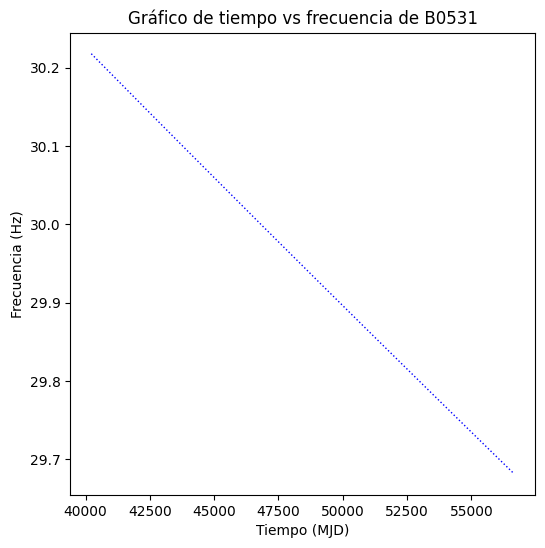

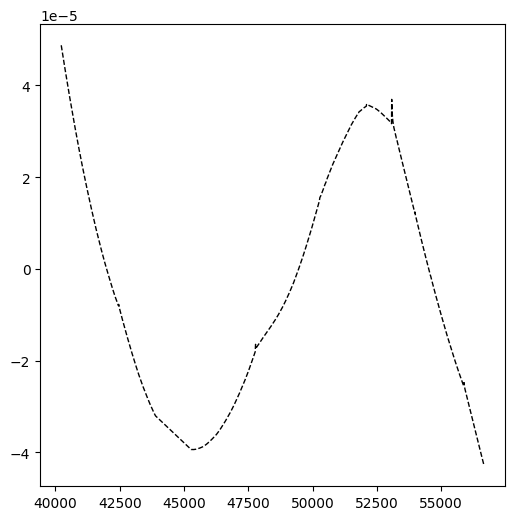

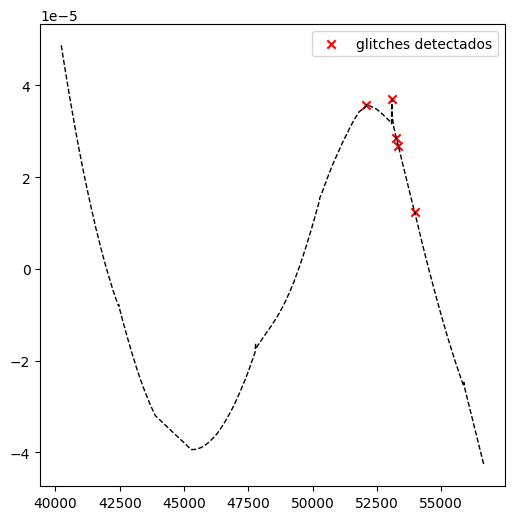

In [28]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoB0531,frecuenciaB0531,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

#calcular residuo:
residuoB0531, coeficientesB0531 = ajuste_residuos_parabola(tiempoB0531,frecuenciaB0531)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoB0531,residuoB0531,linewidth=1,color="black",linestyle="--")
plt.show()

#calculo glotches
glitches, tiempos_glitches_mjd, indices_peaks = obtener_glitches_y_tiempos(residuoB0531, 5, tiempoB0531)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoB0531,residuoB0531,linewidth=1,color="black",linestyle="--")
ax.scatter(tiempos_glitches_mjd, glitches, color='red', marker='x', label="glitches detectados")
plt.legend()
plt.show()



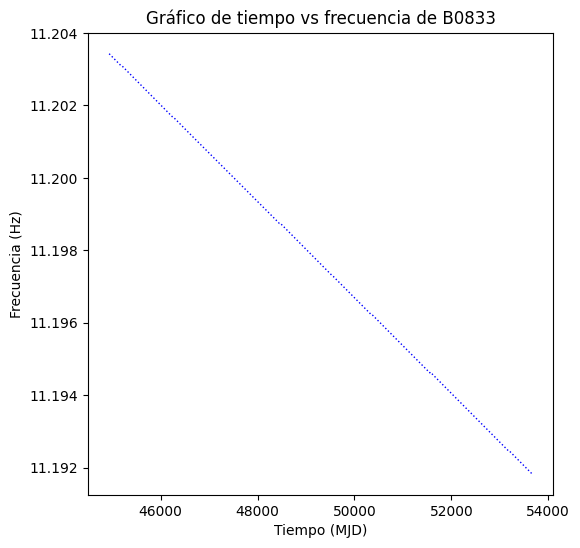

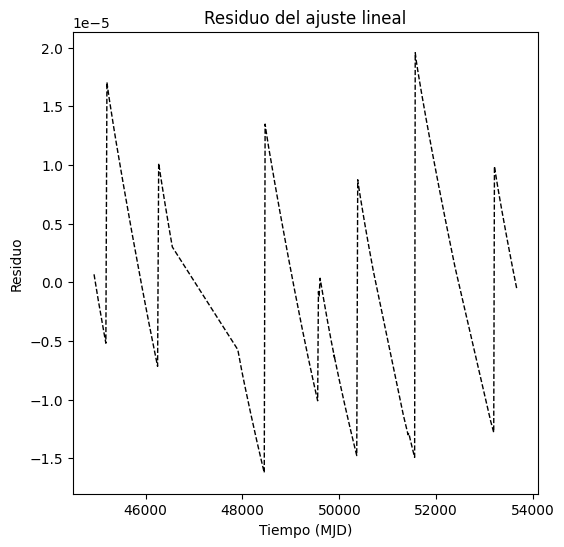

8
8


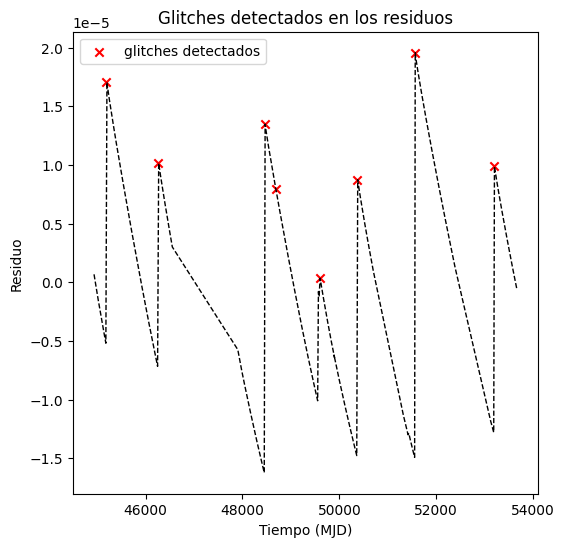

In [29]:
# tiempoB0833, frecuenciaB0833, incertezaB0531 

# Gráfico de tiempo vs frecuencia de B0833
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(tiempoB0833, frecuenciaB0833, color="blue", linewidth=1, linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0833")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")
plt.show()

# Calcular residuo:
residuoB0833, m, b = ajuste_residuos_lineal(tiempoB0833, frecuenciaB0833)

# Gráfico de residuos:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(tiempoB0833, residuoB0833, linewidth=1, color="black", linestyle="--")
ax.set_title("Residuo del ajuste lineal")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Residuo")
plt.show()

# Cálculo de glitches:
glitches, tiempos_glitches_mjd, indices_peaks = obtener_glitches_y_tiempos(residuoB0833, 1, tiempoB0833)

# Gráfico de residuos con glitches detectados:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(tiempoB0833, residuoB0833, linewidth=1, color="black", linestyle="--")

print(len(tiempos_glitches_mjd))
print(len(glitches))

ax.scatter(tiempos_glitches_mjd, glitches, color='red', marker='x', label="glitches detectados")
ax.set_title("Glitches detectados en los residuos")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Residuo")
plt.legend()
plt.show()


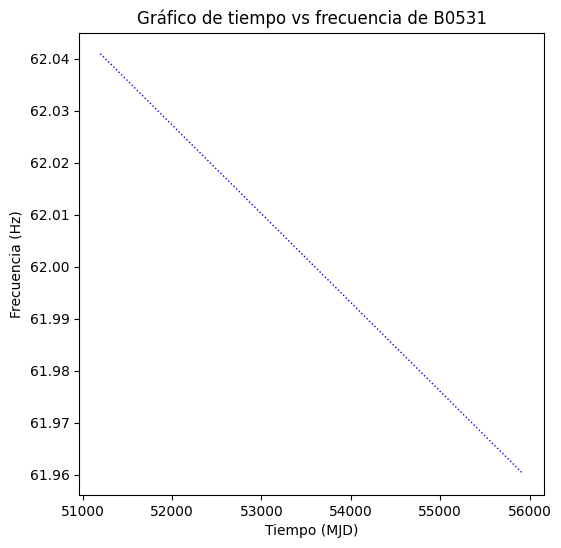

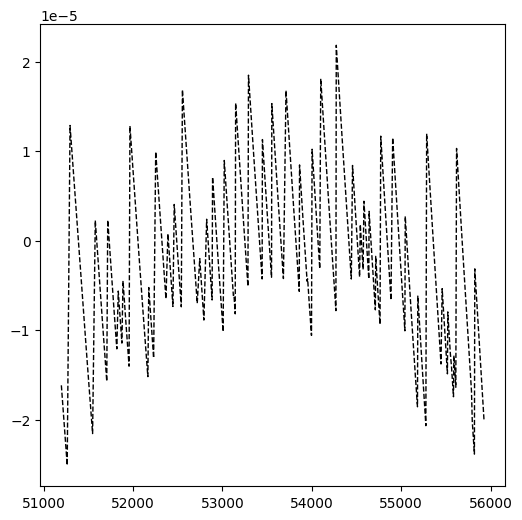

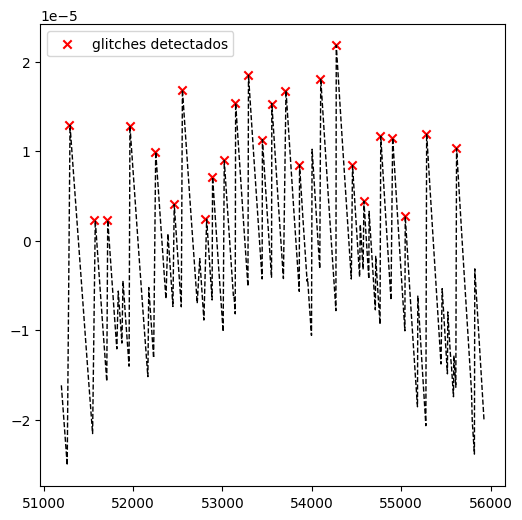

In [30]:
#tiempoJ0537, frecuenciaJ0537, incertezaJ0537
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ0537,frecuenciaJ0537,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

#calcular residuo:
residuoJ0537, m, b = ajuste_residuos_lineal(tiempoJ0537,frecuenciaJ0537)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoJ0537,residuoJ0537,linewidth=1,color="black",linestyle="--")
plt.show()

#calculo glotches
glitches, tiempos_glitches_mjd, indices_peaks = obtener_glitches_y_tiempos(residuoJ0537, 5, tiempoJ0537)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoJ0537,residuoJ0537,linewidth=1,color="black",linestyle="--")
ax.scatter(tiempos_glitches_mjd, glitches, color='red', marker='x', label="glitches detectados")
plt.legend()
plt.show()





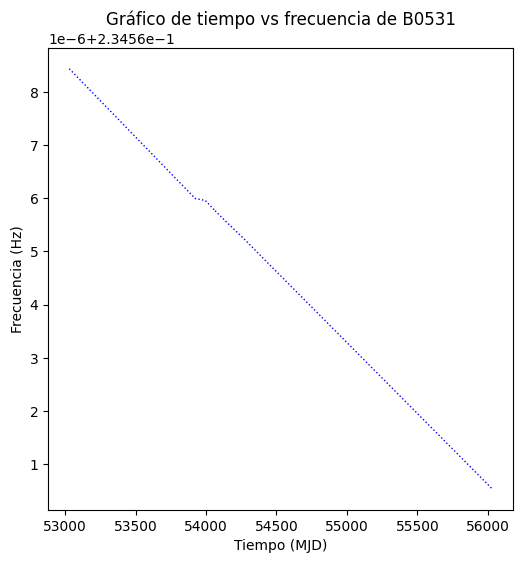

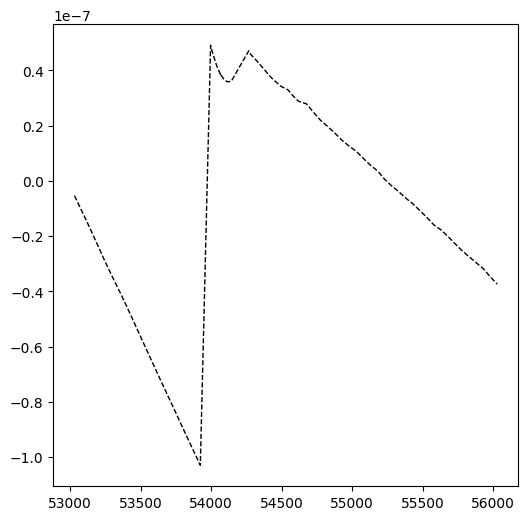

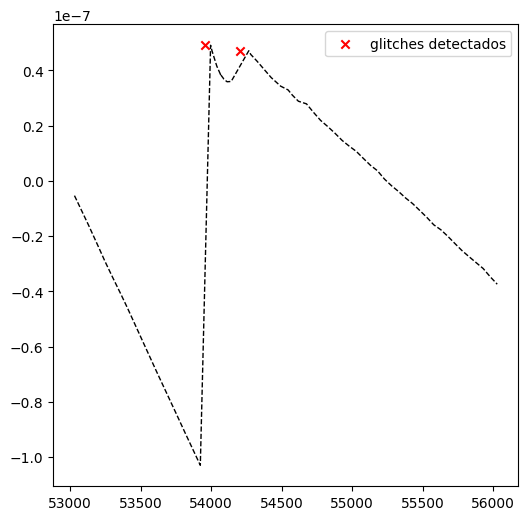

In [31]:
#tiempoJ1819, frecuenciaJ1819, incertezaJ1819
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ1819,frecuenciaJ1819,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

#calcular residuo:
residuoJ1819, m, b = ajuste_residuos_lineal(tiempoJ1819,frecuenciaJ1819)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoJ1819,residuoJ1819,linewidth=1,color="black",linestyle="--")
plt.show()

#calculo glotches
glitches, tiempos_glitches_mjd, indices_peaks = obtener_glitches_y_tiempos(residuoJ1819, 5, tiempoJ1819)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoJ1819,residuoJ1819,linewidth=1,color="black",linestyle="--")
ax.scatter(tiempos_glitches_mjd, glitches, color='red', marker='x', label="glitches detectados")
plt.legend()
plt.show()


